### **INTRODUCTION**

Proteins are macromolecules that help the regularization of our biological system. They affect several pathways in our body and generate many diseases protein problems. Because of this understanding of protein structure and functions is important for creating treatments. Proteins have specific 3D structures and they are dynamic. Experimental methods such as NMR (Nuclear Magnetic Resonance) and SAXS (Small-Angle X-ray Scattering) were first used to analyze the structures of proteins. NMR provides information about protein structure by examining the resonance behavior of atomic nuclei under magnetic fields. In general, the magnetic properties of nuclei such as hydrogen, carbon, and nitrogen in proteins are used. SAXS provides information about the general shape and size of proteins in solution. When the protein is exposed to X-rays, the intensity of the scattered rays at small angles is measured. These methods have certain limitations and disadvantages such as high cost, difficulty in data analysis in large-sized proteins, and technical complexities. 

Simulations were used for the dynamic properties of the obtained 3D structures (Molecular Dynamics simulations), these simulations calculated the new positions of the atoms by taking the distances and movements of each other as reference with physical calculations and created the movements of the protein as a result of these calculations. However, this method also had disadvantages in terms of cost and time. In recent years, the developing field of artificial intelligence has produced developments that are solutions to these problems. The artificial intelligence system alphafold developed by DeepMind has made a great impact in the scientific world by managing to predict the three-dimensional structure of proteins from the amino acid sequence. With alphafold, a deep learning model, specific 3D structures of proteins could be created without using costly techniques. With these developments, current studies have accelerated research to predict the dynamic structures of proteins using artificial intelligence. In the few studies conducted in this field, the coordinate data obtained with md simulations were selected as the data source required for the training of the deep learning model. As a solution to the cost of working and long-term formations of MD simulations, it would be sufficient for the simulation to produce data short enough for the training of the model. This field is quite new in the literature and there are methods that are produced quite quickly. In this study, an variational autoencoder (VAE) model training was performed with the obtained md simulation data and the results were analyzed to examine how successful it was for dynamic structure estimation.

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
   try:
     # Currently, memory growth needs to be the same across GPUs
     for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu, True)
     logical_gpus = tf.config.list_logical_devices('GPU')
     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
     # Memory growth must be set before GPUs have been initialized
     print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
import sys
import time
from copy import deepcopy
import biobox as bb
import numpy as np
from keras import backend as K
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
from keras import regularizers
import MDAnalysis as mda
from MDAnalysis.coordinates import PDB
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

The Atlas website (https://www.dsimb.inserm.fr/ATLAS) is a database containing MD simulation data for many proteins. 3 proteins were selected from this database for the study. Model training was performed using 10,000 frames of data obtained from the simulation of each protein. 
- The first protein, **Non Structural protein 1**, is a protein that plays a critical role in the replication and pathogenesis of influenza A virus. This protein suppresses the immune response of the host cell.
- The second protein, **Metallocarboxypeptidase inhibitor** acts as an inhibitor of metallocarboxypeptidase enzymes. This protein provides controlled degradation of peptides.
- The third protein, **Rubredoxin** is a small iron-sulfur protein found in microorganisms such as anaerobic bacteria and archaea. It plays a role in electron transfer processes.


The main reasons for choosing these 3 proteins are their small size and the fundamental differences in their structures. The first protein has 3 alpha helices, the second protein has 4 beta sheets, and the third protein has both an alpha helix and a beta sheet. I chose these three proteins because my model could be tested in structures with different properties. Alpha helices and beta sheet are structure features fro protein in 3D dimension.


### **METHODS**

### **Data Preprocessing**

1. Convert **pdf** Format Topology and Trajectory Files
2. Atom Selecting
3. Alignment
4. Split Data for Train and Test

MDAnalysis library is a fundamental structure used to represent all the data from molecular dynamics (MD) simulation, including atoms, bonds, molecules, and trajectories.

The Universe class reads simulation files and organizes the atomic details and time-series data into a structure that can be easily analyzed.


In [4]:
def convert_pdb_file(xtc_file, topology_file):
    #creating a universe with topology and trajectory files, Convert format of xtc to pdb 
    pdb_file = "protein.pdb"
    u = mda.Universe(topology_file, xtc_file)
    # each model save in pdb files with used universe class
    with mda.Writer(pdb_file, u.atoms.n_atoms) as writer:
        for ts in u.trajectory:  
            writer.write(u.atoms) 
    return pdb_file

The biobox library used structural biology for analyzing PDB files, visualization of sequence properties etc. Atoms filtered because of reduction dimension of data. These atom selected because they are represent backbone of protein and enough for structure dynamics properties. 

In [5]:
def atom_select(file):
    #provide access to molecular structure  properties
    M = bb.Molecule()
    #pdb files to create molecular objects
    M.import_pdb(file)
    #filtered the atoms 
    idx = M.atomselect("*", "*", ["N", "CA", "C", "O"], get_index=True)[1]
    #retrieves the atomic coordinates
    crds = M.coordinates[:, idx]
    print("> molecule has %s conformations" % M.coordinates.shape[0])
    print("> selected %s atoms" % len(idx))
    return M , crds

Alignment is necessary to ensure accurate analysis of structural properties and meaningful comparisons of conformations.
Without alignment, RMSD calculations may be dominated by the molecule's translation or rotation, rather than actual conformational changes.

In [6]:
def align(M, filename):
    align_pdb = "protein.aligned.pdb"
    idx1 = M.atomselect("*", "*", "CA", get_index=True)[1]
    #calculate the RMSD between structure and all frames in a file
    M.rmsd_one_vs_all(0, points_index=idx1, align=True)
    for pos in range(len(M.coordinates)):
        M.set_current(pos) # sets a spesific trajectory frame as the current frame.
        M.center_to_origin() #centers molecular structure at the origin for alignment
    M.set_current(0)
    M.write_pdb("%s" % filename.replace(".pdb", ".aligned.pdb"))
    return M , align_pdb

**deepcopy()** function provides a robust approach when preparing datasets for deep learning where reshaping and transformations and prevent accidental modifications to the original **crds** (an array representing molecular coordinates) array.

**%30 train data** 

**%70 test data**

In [7]:
def train_test_data(M, crds):
    # split data for train and test data

    indicestrain = np.arange(0, int(0.3 * M.coordinates.shape[0]), 1) #
    indicestest = np.arange(int(0.3 * M.coordinates.shape[0]), M.coordinates.shape[0], 1)
    # train and test dataset generated
    #create a deep copy of selected subset to avoid unintended modifications to the original data
    x_train = deepcopy(crds[indicestrain])
    x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
    #train data shape: (frames, atoms*dimensions)
    x_test = deepcopy(crds[indicestest])
    x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))
    return x_train, x_test 

#### Load to prepared files for deep learning model
1. Save and Load Data
2. Scalling and Normalization
3. Data Augmentation

Save the train and test data with dat format because dat extension is generic and can store a variety of data types and is well-suited for deep learning workflows it can be read easily by python.


In [8]:
def save_load_data(filename, x_train, x_test):
    x_train_file = filename.replace(".pdb", "_train.dat")
    x_test_file = filename.replace(".pdb", "_test.dat")
    
    np.savetxt(x_train_file, x_train)
    np.savetxt(x_test_file, x_test)
    
    x_train_orig = np.loadtxt(x_train_file)
    x_test_orig = np.loadtxt(x_test_file)
    return x_train_orig, x_test_orig

In [9]:
def scalling_normalization(x_train, x_test):
    #Normalization step for scaling the values
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_train_scale = scaler.fit_transform(x_train)
    x_test_scale = scaler.transform(x_test)
    return x_train_scale, x_test_scale 
    

Data Augmentation is technique in deep learning for enhancing the performance and robustness of model. It helps prevent overfitting and generated model generalize to unseen data.

In [10]:
def data_augmentation(x_train_scale, noise):
    noise_xtrain = x_train_scale + noise * np.random.normal(loc=0.0, scale=1.0, size=x_train_scale.shape)
    noise_xtrain = np.clip(noise_xtrain, 0., 1.)
    return noise_xtrain

#### Deep Learning Model
1. Variational Autoencoder (VAE) model
2. Model Training
3. Loss Values 
4. Recounstruction

##### Variational Autoencoder (VAE) Model

In [25]:
def vae_structure(x_train, encoding_dim):
    # encoder
    input_prot = Input(shape=(x_train.shape[1],))

    encoded = Dense(512, activation = 'relu') (input_prot)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = BatchNormalization() (encoded) #Normalizes output for each mini-batch to have a mean of 0 and a variance of 1.
    encoded = Dropout(0.3)(encoded)  # neurons are dropped with a specific probability 
    encoded = Dense(64, activation='relu', kernel_regularizer = regularizers.l2(0.01))(encoded)#adds an L2 penalty to the loss function
    encoded = Dropout(0.2)(encoded) 
    encoded = Dense(16, activation = 'relu')(encoded)
    #outputs the mean of the latent distribution
    encode_mean = Dense(encoding_dim)(encoded)
    #outputs the logarithm of the variance of the latent distribution 
    encode_log_var = Dense(encoding_dim)(encoded)
    #uses mean and variance to sample from the latent space using reparameterization trick
    sample = Lambda(sampling, name='sampling')([encode_mean, encode_log_var])
    
    encoder = Model(input_prot, sample)

    #decoder
    decoded = Dense(16, activation='relu')(sample)
    decoded = Dense(64, activation='relu')(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = Dense(x_train.shape[1], activation='sigmoid')(decoded)

    sampling_model = Model(input_prot, decoded)

    # define loss, optimizer
    #Reconstruction Loss
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    xent_loss = K.mean(msle(input_prot, decoded))
    
    #KL divergence loss
    kl_loss = -1e-3 * K.mean(1 + encode_log_var - K.square(encode_mean) - K.exp(encode_log_var))
    vae_loss = K.mean(xent_loss +  kl_loss)  

    sampling_model.add_loss(vae_loss)

    adam = Adam(learning_rate=0.0005)
    sampling_model.compile(optimizer=adam, metrics='mean_squared_error')

    return encoder, sampling_model

**Reparameterization Trick**

Separating the stochastic component from deterministic components. This allows the network to learn meaningful latent space representations through gradient updates.

In [12]:
def sampling(arg):
    mean = arg[0] 
    logvar = arg[1]
    epsilon = K.random_normal(shape=K.shape(mean), mean=0.5, stddev=1.) #generate random noise
    return mean + K.exp(0.5 * logvar) * epsilon

##### Model Training

In [13]:

def model_training(Batch_size, epochs, xtrain, xtest):
    integral_model = vae_structure(xtrain, 4)
    encoder = integral_model[0]
    sampling_model = integral_model[1]
    
    #adding early stopping that means stops training when validation performance stops improving
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = sampling_model.fit(
        xtrain, xtrain,
        epochs=epochs,
        batch_size=Batch_size,
        shuffle=True,
        validation_data=(xtest, xtest),
        callbacks=[early_stopping]
    )
    return history , sampling_model

##### Loss Values 

In [14]:
def plot_results(history):
     # plot for training nd validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

##### Recounstruction

In [15]:
def reconstruct(noise_xtrain, x_test_scale ,model, x_train_orig, x_test_orig):
    scaler = MinMaxScaler(feature_range=(0, 1))
    noise_xtrain = scaler.fit_transform(x_train_orig) #scaling the data
    rc_train = model.predict(noise_xtrain) #predict with used model for train data
    reconstruct_train = scaler.inverse_transform(rc_train) # reconstructing original data range
    decoded_reshaped_train = reconstruct_train.reshape(reconstruct_train.shape[0],
                                                        int(reconstruct_train.shape[1] / 3), 3) # 3Dimension shape 
    
    x_test_scale = scaler.fit_transform(x_test_orig)
    rc_test = model.predict(x_test_scale) #predict with test data
    reconstruct_test = scaler.inverse_transform(rc_test)
    decoded_reshaped_test = reconstruct_test.reshape(reconstruct_test.shape[0], int(reconstruct_test.shape[1] / 3), 3)
    return decoded_reshaped_train,reconstruct_train, decoded_reshaped_test, reconstruct_test

### Analyzing Results
1. Spearman Correlation
2. Generating Structure
3. RMSD (Root Mean Squared Deviation)
4. Box Plot

##### Spearman Correlation Coefficient

The performance of the Spearman correlation coefficient values was analyzed on both the training and test sets for each protein. The sequential relationships of the protein structures generated by the model were compared with the original structures.

In [16]:
#Spearman rank correlation coefficient
def spearman_corr(y_true, y_pred):
    sprm = 0
    for i in range(y_true.shape[0]):
        sprm += stats.spearmanr(y_true[i], y_pred[i])[0]
    sprm = sprm / y_true.shape[0]
    return sprm

In [17]:
def spearman_corr_each_example(y_true, y_pred):
    correlation_coeffs = []
    for i in range(y_true.shape[0]):
        corr, _ = stats.spearmanr(y_true[i], y_pred[i])  # Korelasyonu hesapla
        correlation_coeffs.append(corr)  # Korelasyonu listeye ekle
    return correlation_coeffs


##### Generate PDB file that contains reconstructed of protein

In [19]:
def generate_pdb(filename, decoded_reshaped_test, M):
        
    M2 = bb.Molecule() #create molecule object
    M2.import_pdb(filename)
    idx2 = M.atomselect("*", "*", ["N", "CA", "C", "O"], get_index=True)[1] #select atoms
    
    M3 = M.get_subset(idxs=idx2, conformations=[0]) #subset of molecule
    M3.coordinates = decoded_reshaped_test #assign reconstructed coordinates
    M3.write_pdb("%s" % filename.replace(".pdb", ".generated.pdb")) #write new pdb file


##### RMSD calculation
RMSD (Root Mean Squared) calculate how similar the conformations of two sets of molecular structures are,, by computing the RMSD between the corresponding atomic cooordinates.

In [45]:
import os
from copy import deepcopy
import biobox as bb
import numpy as np

def RMSD_calculation(filename, output_filename):
    def cal_rmsd(input_data, output, test_size):
        test = deepcopy(input_data)  # The original dataset
        examine = deepcopy(output)  # The generated dataset
        rmsd_values = []

        for j in range(0, test_size):
            test.add_xyz(examine[j])  # Add the generated structure to the test set
        
        for i in range(0, test_size, 3):
            for j in range(0, test_size, 3):
                val = test.rmsd(i, test_size + j)  # Calculate RMSD between structures
                rmsd_values.append(val)
        
        return rmsd_values

    # Load original PDB file and select atoms
    M = bb.Molecule()
    M.import_pdb(f"{filename.replace('.pdb', '.aligned.pdb')}")
    idx = M.atomselect("*", "*", ["N", "CA", "C", "O"], get_index=True)[1]
    crds = M.coordinates[:, idx]
    indices = np.random.permutation(len(crds))

    # Split dataset for train/test
    split_index = int(float(0.3) * len(indices))
    indicestest = np.sort(indices[split_index:])  # Select test set conformations
    M2 = M.get_subset(idxs=idx, conformations=indicestest)

    # Load generated structure and select atoms
    M1 = bb.Molecule()
    M1.import_pdb(f"{filename.replace('.pdb', '.aligned.generated.pdb')}")
    idx = M1.atomselect("*", "*", ["N", "CA", "C", "O"], get_index=True)[1]
    M3 = M1.get_subset(idxs=idx)

    # Calculate RMSD
    test_size = len(M.coordinates) - split_index
    comp_test = cal_rmsd(M2, M3, test_size)
    comp_test = np.array(comp_test)

    # Print the average RMSD
    print("> Average RMSD: %.3f Å" % np.mean(comp_test))

    # Save RMSD values to the current working directory
    output_path = os.path.join(os.getcwd(), output_filename)
    np.savetxt(output_path, comp_test)
    print(f"RMSD values saved to: {output_path}")

    return output_path


Box plot shows RMSD values that calculated for each protein between original structure and generated structure.

In [2]:
def box_plot(rmsd_1, rmsd_2, rmsd_3, lab1, lab2, lab3):
    plt.boxplot([rmsd_1, rmsd_2, rmsd_3], labels=[lab1, lab2, lab3])

    plt.title("RMSD Values Between Generated and Original Structure")
    plt.xlabel("Protein ID")
    plt.ylabel("RMSD Values")
    
    plt.show()

### **RESULTS**

## **1AIL** 

In [3]:
new_directory_1AIL = "C://Users//90535//proteins//1AIL"

os.chdir(new_directory_1AIL)

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\90535\proteins\1AIL


In [22]:
pdb_file_1AIL = convert_pdb_file("1ail_A_prod_R1_fit.xtc", "1ail_A.pdb")

In [23]:
M1, crds_1AIL = atom_select(pdb_file_1AIL)
#aligning 
print("> align conformations ...")
time0 = time.time()
M_1AIL, align_pdb_1AIL = align(M1, pdb_file_1AIL)
print("  alignment completed, takes %.2f s" % (time.time()-time0))

> molecule has 10001 conformations
> selected 291 atoms
> align conformations ...
  alignment completed, takes 3950.09 s


In [24]:
x_train_1AIL, x_test_1AIL = train_test_data(M_1AIL,crds_1AIL)
x_train_orig_1AIL, x_test_orig_1AIL = save_load_data(align_pdb_1AIL, x_train_1AIL, x_test_1AIL)
x_train_scale_1AIL, x_test_scale_1AIL = scalling_normalization(x_train_orig_1AIL, x_test_orig_1AIL)
noise_xtrain_1AIL = data_augmentation(x_train_scale_1AIL, 0.01)

Epoch 1/300
94/94 [==============================] - 7s 46ms/step - loss: 0.6496 - mean_squared_error: 0.0246 - val_loss: 0.3658 - val_mean_squared_error: 0.0532
Epoch 2/300
94/94 [==============================] - 3s 37ms/step - loss: 0.2089 - mean_squared_error: 0.0199 - val_loss: 0.1200 - val_mean_squared_error: 0.0476
Epoch 3/300
94/94 [==============================] - 4s 38ms/step - loss: 0.0630 - mean_squared_error: 0.0185 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 4/300
94/94 [==============================] - 5s 49ms/step - loss: 0.0211 - mean_squared_error: 0.0177 - val_loss: 0.0244 - val_mean_squared_error: 0.0416
Epoch 5/300
94/94 [==============================] - 5s 50ms/step - loss: 0.0108 - mean_squared_error: 0.0165 - val_loss: 0.0189 - val_mean_squared_error: 0.0380
Epoch 6/300
94/94 [==============================] - 4s 42ms/step - loss: 0.0086 - mean_squared_error: 0.0157 - val_loss: 0.0180 - val_mean_squared_error: 0.0373
Epoch 7/300
94/94 [=========

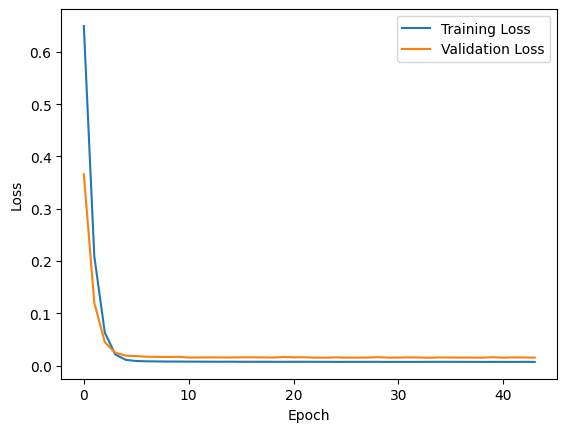

219/219 [==============================] - 1s 7ms/step


In [27]:
history_1AIL, sampling_model_1AIL= model_training(32, 300, noise_xtrain_1AIL, x_test_scale_1AIL)
plot_results(history_1AIL)
decoded_reshaped_train_1AIL,reconstruct_train_1AIL, decoded_reshaped_test_1AIL, reconstruct_test_1AIL =  reconstruct(noise_xtrain_1AIL,
                                                                                                                    x_test_scale_1AIL,
                                                                                                                    sampling_model_1AIL,
                                                                                                                    x_train_orig_1AIL,
                                                                                                                    x_test_orig_1AIL)


In [28]:
spr = spearman_corr(x_train_orig_1AIL, reconstruct_train_1AIL)
spr_test = spearman_corr(x_test_orig_1AIL, reconstruct_test_1AIL)
print("> spearman corelation coefficients:\n  train set: %.3f\n  test set: %.3f" % (spr, spr_test))

> spearman corelation coefficients:
  train set: 0.998
  test set: 0.988


The correlation on the test set is slightly lower than on the training set, indicating that the model generalizes well but experiences a slight performance drop on the test data. 

In [30]:
generate_pdb(align_pdb_1AIL, decoded_reshaped_test_1AIL,M_1AIL)

In [46]:
RMSD_calculation(pdb_file_1AIL, "rmsd_1AIL.dat")


> Average RMSD: 2.743 Å
RMSD values saved to: C:\Users\90535\proteins\1AIL\rmsd_1AIL.dat


'C:\\Users\\90535\\proteins\\1AIL\\rmsd_1AIL.dat'

In [5]:
rmsd_1AIL = np.loadtxt("rmsd_1AIL.dat")

## **1DTD**

In [6]:

new_directory_1DTD = "C://Users//90535//proteins//1DTD"

os.chdir(new_directory_1DTD)

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\90535\proteins\1DTD


In [48]:
pdb_file_1DTD = convert_pdb_file("1dtd_B_prod_R1_fit.xtc", "1dtd_B.pdb")

In [49]:
M2, crds_1DTD = atom_select(pdb_file_1DTD)
#aligning 
print("> align conformations ...")
time0 = time.time()
M_1DTD , align_pdb_1DTD = align(M2, pdb_file_1DTD)
print("  alignment completed, takes %.2f s" % (time.time()-time0))

> molecule has 10001 conformations
> selected 243 atoms
> align conformations ...
  alignment completed, takes 2773.93 s


In [50]:
x_train_1DTD, x_test_1DTD = train_test_data(M_1DTD,crds_1DTD)
x_train_orig_1DTD, x_test_orig_1DTD = save_load_data(align_pdb_1DTD, x_train_1DTD, x_test_1DTD)
x_train_scale_1DTD, x_test_scale_1DTD = scalling_normalization(x_train_orig_1DTD, x_test_orig_1DTD)
noise_xtrain_1DTD = data_augmentation(x_train_scale_1DTD, 0.01)

Epoch 1/200
94/94 [==============================] - 7s 41ms/step - loss: 0.6337 - mean_squared_error: 0.0225 - val_loss: 0.3511 - val_mean_squared_error: 0.0510
Epoch 2/200
94/94 [==============================] - 3s 32ms/step - loss: 0.2032 - mean_squared_error: 0.0215 - val_loss: 0.1139 - val_mean_squared_error: 0.0516
Epoch 3/200
94/94 [==============================] - 3s 34ms/step - loss: 0.0618 - mean_squared_error: 0.0211 - val_loss: 0.0412 - val_mean_squared_error: 0.0494
Epoch 4/200
94/94 [==============================] - 3s 35ms/step - loss: 0.0214 - mean_squared_error: 0.0203 - val_loss: 0.0226 - val_mean_squared_error: 0.0488
Epoch 5/200
94/94 [==============================] - 3s 36ms/step - loss: 0.0117 - mean_squared_error: 0.0198 - val_loss: 0.0190 - val_mean_squared_error: 0.0493
Epoch 6/200
94/94 [==============================] - 3s 35ms/step - loss: 0.0097 - mean_squared_error: 0.0195 - val_loss: 0.0187 - val_mean_squared_error: 0.0503
Epoch 7/200
94/94 [=========

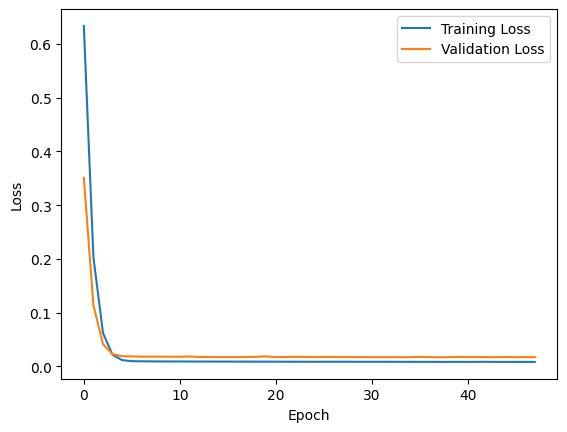

219/219 [==============================] - 1s 6ms/step


In [51]:
history_1DTD, sampling_model_1DTD = model_training(32, 200, noise_xtrain_1DTD, x_test_scale_1DTD)
plot_results(history_1DTD)
decoded_reshaped_train_1DTD,reconstruct_train_1DTD, decoded_reshaped_test_1DTD, reconstruct_test_1DTD =  reconstruct(noise_xtrain_1DTD,
                                                                                                                     x_test_scale_1DTD,
                                                                                                                     sampling_model_1DTD, 
                                                                                                                    x_train_orig_1DTD,
                                                                                                                    x_test_orig_1DTD)


In [52]:
spr_1DTD = spearman_corr(x_train_orig_1DTD, reconstruct_train_1DTD)
spr_test_1DTD = spearman_corr(x_test_orig_1DTD, reconstruct_test_1DTD)
print("> spearman corelation coefficients:\n  train set: %.3f\n  test set: %.3f" % (spr_1DTD, spr_test_1DTD))

> spearman corelation coefficients:
  train set: 0.998
  test set: 0.995


High correlation was observed in both the training and test sets. Considering the RMSD values of this protein, the model produced one of the most successful results, effectively capturing both sequential relationships and atomic-level details.

In [53]:
generate_pdb(align_pdb_1DTD, decoded_reshaped_test_1DTD, M_1DTD)

In [54]:
RMSD_calculation(pdb_file_1DTD, "rmsd_1DTD.dat")

> Average RMSD: 1.302 Å
RMSD values saved to: C:\Users\90535\proteins\1DTD\rmsd_1DTD.dat


'C:\\Users\\90535\\proteins\\1DTD\\rmsd_1DTD.dat'

In [8]:
rmsd_1DTD = np.loadtxt("rmsd_1DTD.dat")

## **1BQ8**

In [9]:
new_directory_1BQ8 = "C://Users//90535//proteins//1BQ8"

os.chdir(new_directory_1BQ8)

print("Current working directory:", os.getcwd())


Current working directory: C:\Users\90535\proteins\1BQ8


In [56]:
pdb_file_1BQ8 = convert_pdb_file("1bq8_A_prod_R1_fit.xtc", "1bq8_A.pdb")

In [57]:
M3, crds_1BQ8 = atom_select(pdb_file_1BQ8)
print("> align conformations ...")
time0 = time.time()
M_1BQ8,align_pdb_1BQ8  = align(M3, pdb_file_1BQ8)
print("  alignment completed, takes %.2f s" % (time.time()-time0))

> molecule has 10001 conformations
> selected 215 atoms
> align conformations ...
  alignment completed, takes 2341.48 s


In [58]:
x_train_1BQ8, x_test_1BQ8 = train_test_data(M_1BQ8,crds_1BQ8)
x_train_orig_1BQ8, x_test_orig_1BQ8 = save_load_data(align_pdb_1BQ8,x_train_1BQ8, x_test_1BQ8)
x_train_scale_1BQ8, x_test_scale_1BQ8 = scalling_normalization(x_train_orig_1BQ8, x_test_orig_1BQ8)
noise_xtrain_1BQ8 = data_augmentation(x_train_scale_1BQ8, 0.01)

Epoch 1/200
94/94 [==============================] - 7s 41ms/step - loss: 0.6372 - mean_squared_error: 0.0234 - val_loss: 0.3435 - val_mean_squared_error: 0.0209
Epoch 2/200
94/94 [==============================] - 3s 34ms/step - loss: 0.2037 - mean_squared_error: 0.0210 - val_loss: 0.1043 - val_mean_squared_error: 0.0199
Epoch 3/200
94/94 [==============================] - 3s 34ms/step - loss: 0.0613 - mean_squared_error: 0.0196 - val_loss: 0.0322 - val_mean_squared_error: 0.0199
Epoch 4/200
94/94 [==============================] - 3s 34ms/step - loss: 0.0210 - mean_squared_error: 0.0193 - val_loss: 0.0137 - val_mean_squared_error: 0.0196
Epoch 5/200
94/94 [==============================] - 3s 37ms/step - loss: 0.0113 - mean_squared_error: 0.0189 - val_loss: 0.0099 - val_mean_squared_error: 0.0197
Epoch 6/200
94/94 [==============================] - 3s 37ms/step - loss: 0.0095 - mean_squared_error: 0.0186 - val_loss: 0.0092 - val_mean_squared_error: 0.0194
Epoch 7/200
94/94 [=========

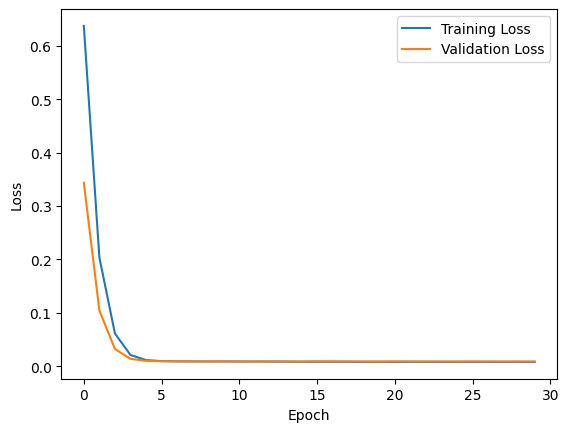

219/219 [==============================] - 1s 5ms/step


In [59]:
history_1BQ8, sampling_model_1BQ8 = model_training(32, 200, noise_xtrain_1BQ8, x_test_scale_1BQ8)
plot_results(history_1BQ8)
decoded_reshaped_train_1BQ8,reconstruct_train_1BQ8, decoded_reshaped_test_1BQ8, reconstruct_test_1BQ8 =  reconstruct(x_train_orig_1BQ8,
                                                                                                                     x_test_orig_1BQ8,
                                                                                                                    sampling_model_1BQ8,
                                                                                                                    x_train_orig_1BQ8,
                                                                                                                    x_test_orig_1BQ8)
                                                                                                                    

In [60]:
spr_1BQ8 = spearman_corr(x_train_orig_1BQ8, reconstruct_train_1BQ8)
spr_test_1BQ8 = spearman_corr(x_test_orig_1BQ8, reconstruct_test_1BQ8)
print("> spearman corelation coefficients:\n  train set: %.3f\n  test set: %.3f" % (spr_1BQ8, spr_test_1BQ8))

> spearman corelation coefficients:
  train set: 0.998
  test set: 0.996


The correlation on the test set is higher than on the training set. This may indicate overfitting, or it could suggest that the test data and training data are quite similar, or that the learned features align better with the test data.

In [61]:
generate_pdb(align_pdb_1BQ8, decoded_reshaped_test_1BQ8, M_1BQ8)

In [62]:
RMSD_calculation(pdb_file_1BQ8, "rmsd_1BQ8.dat")

> Average RMSD: 0.979 Å
RMSD values saved to: C:\Users\90535\proteins\1BQ8\rmsd_1BQ8.dat


'C:\\Users\\90535\\proteins\\1BQ8\\rmsd_1BQ8.dat'

In [10]:
rmsd_1BQ8 = np.loadtxt("rmsd_1BQ8.dat")

C:\Users\90535\AppData\Local\Temp\ipykernel_52476\1820290416.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([rmsd_1, rmsd_2, rmsd_3], labels=[lab1, lab2, lab3])


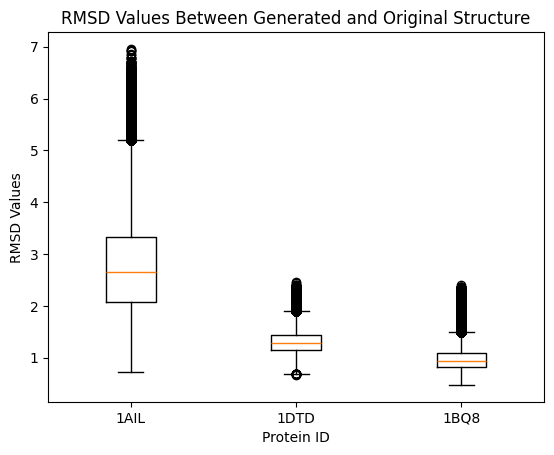

In [11]:
box_plot(rmsd_1AIL, rmsd_1DTD, rmsd_1BQ8, '1AIL', '1DTD', '1BQ8')

To analyze the results, the RMSD values between the dynamic structures obtained using the deep learning model and the original dynamic structures were calculated. This calculation was performed for all three proteins, and the results were presented in a box plot. For the **first protein**, most of the average RMSD values were observed to be concentrated between 2 and 3.5 Å. The graph also shows that there are numerous outliers above 5 Å. The presence of excessive outliers may indicate that certain conformations were not accurately predicted by the model or that the protein structure exhibits significant flexibility.
The values for the **second protein** are mostly observed to vary between 1 and 1.7 Å, with fewer outliers compared to the first protein. Therefore, it can be concluded that the dynamics of this protein were better captured by the model.
For the **third protein**, the values generally range between 0.8 and 1.2 Å. The low RMSD values indicate that the protein dynamics were learned effectively by the model. However, this might suggest a low generalization capacity of the model due to overfitting, where it learned the specific structure of the protein too well.

### **REFERENCES**

1. Zhu, J. J., Zhang, N. J., Wei, T., & Chen, H. F. (2023). Enhancing conformational sampling for intrinsically disordered and ordered proteins by Variational autoencoder. International Journal of Molecular Sciences, 24(8), 6896.
2. Gupta, A., Dey, S., Hicks, A., & Zhou, H. X. (2022). Artificial intelligence guided conformational mining of intrinsically disordered proteins. Communications biology, 5(1), 610.
3. Janson, G., Valdes-Garcia, G., Heo, L., & Feig, M. (2023). Direct generation of protein conformational ensembles via machine learning. Nature Communications, 14(1), 774.